In [2]:
from lib import create_dataframe

sample = 1.0
te = create_dataframe('task_events', 1, sample=sample)
tc = create_dataframe('task_constraints', 1, sample=sample)

Will download at most 1 file(s) from task_events.
Polling bucket gs://clusterdata-2011-2/task_events
Dowloading [/part-00000-of-00500.csv.gz]
Successfully downloaded table [task_events] (1/500).
Will download at most 1 file(s) from task_constraints.
Polling bucket gs://clusterdata-2011-2/task_constraints
Dowloading [/part-00000-of-00500.csv.gz]
Successfully downloaded table [task_constraints] (1/500).


In [3]:
from pyspark.sql import functions as F

# Select the first timestamp at which all processes enter in PENDING state
# Only the first wait period in this state interests us
submit_status = te.select(te.job_id, te.task_index, te.event_type, te.time.cast('double'))\
    .filter(te.event_type == '0').drop(te.event_type)\
    .withColumnRenamed('time', 'time_start_pending')

submit_status.take(5)

[Row(job_id='3418309', task_index='0', time_start_pending=0.0),
 Row(job_id='3418309', task_index='1', time_start_pending=0.0),
 Row(job_id='3418314', task_index='0', time_start_pending=0.0),
 Row(job_id='3418314', task_index='1', time_start_pending=0.0),
 Row(job_id='3418319', task_index='0', time_start_pending=0.0)]

In [4]:
inpending = submit_status.groupBy(['job_id', 'task_index']).min('time_start_pending')
inpending = inpending.withColumnRenamed('min(time_start_pending)','time_start_pending')
inpending.take(5)

[Row(job_id='17109330', task_index='90', time_start_pending=0.0),
 Row(job_id='17109330', task_index='162', time_start_pending=0.0),
 Row(job_id='192299653', task_index='35', time_start_pending=0.0),
 Row(job_id='192299653', task_index='272', time_start_pending=0.0),
 Row(job_id='515042969', task_index='19', time_start_pending=0.0)]

In [5]:
# Select the first timestamp at which all processes exit the PENDING state
outpending_status = te.select(te.job_id, te.task_index, te.event_type, te.time.cast('double'))\
    .filter(te.event_type.isin(['1', '3', '5', '6'])).drop(te.event_type)\
    .withColumnRenamed('time', 'time_end_pending')
outpending_status.take(5)

[Row(job_id='3418309', task_index='0', time_end_pending=0.0),
 Row(job_id='3418309', task_index='1', time_end_pending=0.0),
 Row(job_id='3418314', task_index='0', time_end_pending=0.0),
 Row(job_id='3418314', task_index='1', time_end_pending=0.0),
 Row(job_id='3418319', task_index='0', time_end_pending=0.0)]

In [6]:
outpending = outpending_status.groupBy(['job_id', 'task_index']).min('time_end_pending')
outpending = outpending.withColumnRenamed('min(time_end_pending)','time_end_pending')

outpending.take(5)

[Row(job_id='17109330', task_index='90', time_end_pending=0.0),
 Row(job_id='17109330', task_index='162', time_end_pending=0.0),
 Row(job_id='192299653', task_index='35', time_end_pending=0.0),
 Row(job_id='192299653', task_index='272', time_end_pending=0.0),
 Row(job_id='515042969', task_index='19', time_end_pending=0.0)]

In [7]:
# Join both sanitized dataframes together on job id and task id
fullpending = inpending.join(outpending, ['job_id', 'task_index'])


In [8]:
# Compute the delta for each occurence (time spent in pending state computed from both time_start_pending and time_end_pending)
fullpending_with_delta = fullpending.withColumn(
    'delta_time', F.col('time_end_pending') - F.col('time_start_pending')
)
fullpending_with_delta = fullpending_with_delta.select('job_id', 'delta_time')

In [9]:
# Compute the mean delta time for each job
fullpending_with_delta = fullpending_with_delta.groupBy('job_id').mean('delta_time')
fullpending_with_delta.take(5)


[Row(job_id='5007846463', avg(delta_time)=0.0),
 Row(job_id='6252092106', avg(delta_time)=1504793.0),
 Row(job_id='6127575571', avg(delta_time)=0.0),
 Row(job_id='5943138316', avg(delta_time)=0.0),
 Row(job_id='5556388735', avg(delta_time)=0.0)]

In [10]:
cons_jt = tc.select(tc.job_id, tc.task_index)
cons_jt = cons_jt.groupBy(cons_jt.job_id, cons_jt.task_index).count()
cons_jt = cons_jt.drop('task_index').groupBy('job_id').mean('count')
cons_jt = cons_jt.filter(cons_jt['avg(count)'] < 50)

cons_jt.take(5)

[Row(job_id='5007846463', avg(count)=3.0166666666666666),
 Row(job_id='6127575571', avg(count)=2.0),
 Row(job_id='5556388735', avg(count)=4.0),
 Row(job_id='6251625600', avg(count)=3.0),
 Row(job_id='6127571338', avg(count)=2.0)]

<AxesSubplot:xlabel='avg(count)', ylabel='avg(delta_time)'>

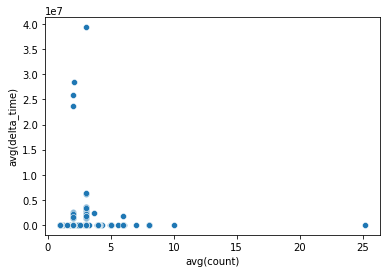

In [11]:
import seaborn as sns
# Join the number of constraints with the delta time dataframe
full_df = fullpending_with_delta.join(cons_jt, on='job_id')

data = full_df.select('avg(delta_time)', 'avg(count)').toPandas()


sns.scatterplot(data=data, x='avg(count)', y="avg(delta_time)")
